# Dog Cat Classification

In this notebook I will be using a customized CNN model and VGG16 and MobileNetV2 with transfer learning to perform a classifiation task on cat and dogs. I will compare the accuracy and training time of these three models, and the accuracy of customized CNN model with and without a data augmentation.

## 1 - Package import 

In [106]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import random

import tensorflow as tf
import tensorflow.keras.layers as tfl

from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

Set seed for reproductivity

In [107]:
from numpy.random import seed
seed(1)

tf.random.set_seed(2)

## 2 - Data Import

The data provided on Kaggle kernel is zip file, so expand the file first.

In [108]:
train_path = '../input/dogs-vs-cats/train.zip'
test_path = '../input/dogs-vs-cats/test1.zip'

# save all files to kaggle/files/images
destination = '/kaggle/files/images'

from zipfile import ZipFile as zipper
with zipper(train_path, 'r') as zipp:
    zipp.extractall(destination)
    
with zipper(test_path, 'r') as zipp:
    zipp.extractall(destination)

In [109]:
# create a pandas dataframe
train = pd.DataFrame({'file': os.listdir('/kaggle/files/images/train')})

categories = []
for i in os.listdir('/kaggle/files/images/train'):
    if 'dog' in i:
        categories.append(1)
    else:
        categories.append(0)
        
train['categories'] = categories

In [110]:
train.head()

,file,categories
0,dog.890.jpg,1
1,dog.1178.jpg,1
2,dog.7845.jpg,1
3,dog.4632.jpg,1
4,cat.3660.jpg,0


## 3 - Visualize an example 

<class 'numpy.ndarray'>
(255, 319, 3)
<class 'tuple'>


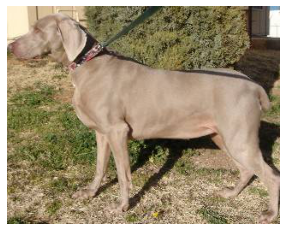

In [111]:
def example_im(index):
    '''
    Function to display an example image.
    
    index -- which image in the training set. 
    '''
    im = plt.imread('/kaggle/files/images/train/'+str(train['file'][index]))

    print(type(im))
    print(im.shape)
    print(type(im.shape))
    
    plt.imshow(im)
    plt.axis('off')
    
example_im(1)

## 4 - Data Preparation 

In [112]:
train['categories'].value_counts()

1    12500
0    12500
Name: categories, dtype: int64

For our data, we have same number of cats and dogs in training data.

In [113]:
train.shape

(25000, 2)

The numeric varaible in `categories` columns is mapped to string for later image generation

The training data is not a particularly small dataset so we can use `10%` of its data as a `cross validation set`, and `random_state` is set to be 0 for reproductivity.

In [114]:
train['categories'] = train['categories'].replace({0: 'cat', 1: 'dog'})
train_set, val_set = train_test_split(train, test_size=0.1, random_state = 0)

We are going to use mini-batch optimization to train our model. Typically a Convolutional neural network has millions or tens of millions of parameters to train, so mini-batch can largely increase our training speed and shorten the iteration time. The `batch_size` is selected to be 64 here. Also the normalization (1./255 rescaling) is used for train and validation generator. 

In [115]:
# creating generators
train_gen_scaled = ImageDataGenerator(rescale=1./255)
val_gen_scaled = ImageDataGenerator(rescale=1./255)

batch_size = 64

# generating from data frame 
train_generator_scaled = train_gen_scaled.flow_from_dataframe(
    dataframe = train_set,
    directory = destination + '/train/', # file path format
    x_col = 'file',
    y_col = 'categories',
    class_mode = 'categorical',
    target_size = (224,224),
    batch_size = batch_size
)

validation_generator_scaled = val_gen_scaled.flow_from_dataframe(
    dataframe = val_set,
    directory = destination + '/train/',
    x_col = 'file',
    y_col = 'categories',
    class_mode = 'categorical',
    target_size = (224,224),
    batch_size = batch_size,
    shuffle = False # ensure the validation and prediction are not random
)


Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


## 5 - Example mini batch

Found 22500 validated image filenames belonging to 2 classes.


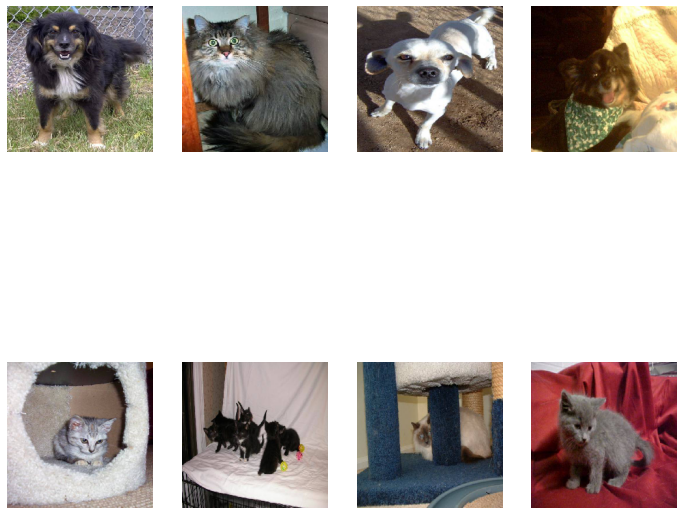

In [116]:
def mini_batch_example_plot(df):
    '''
    This function creates 8 examples plots.
    
    df - the dataframe containing examples 
    '''
    # create an another generator for training set
    example_generator = train_gen_scaled.flow_from_dataframe(
        dataframe = df,
        directory = destination + '/train/',
        x_col = 'file',
        y_col = 'categories',
        class_mode = 'categorical',
        target_size = (224,224)
    )
    
    fig, ax  = plt.subplots(2,4,figsize=(12, 12))
    ax = ax.flatten()
    
    for i in range(8):
        X, Y = next(example_generator)
        image = X[0]
        ax[i].imshow(image)
        ax[i].axis('off')
    
    
mini_batch_example_plot(train_set)

## 6 - Customized CNN model construction

In [117]:
# import the layers we will be using to construct our model 
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
# import data augmentation tools
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


In [118]:
# set constants, the input size is set to be the default size
(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS) = (224,224,3)
IMAGE_SIZE  = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_SHAPE = (224,224,3)

Here we create a function that generates a customized CNN network.

In [119]:
def shallow_CNN_Model(image_shape, augmentation = False):
    '''
    This creates a shallow CNN model, the structure uses the idea from VGG-16
    
    image_shape - shape of input images
    augmentation - with or without data augmentation, default is False
    '''
    # decide whether to add augmentation layers, the augmentation methods include random
    # flip and random rotate
    if (augmentation == True):
        model = tf.keras.Sequential([RandomFlip("horizontal",input_shape = image_shape),
                   RandomRotation(0.1)])
    else: 
        model = tf.keras.Sequential()

    # build a model with four main sections
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape = image_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    return model

In [120]:
# begin creating a model 
model = shallow_CNN_Model(IMAGE_SHAPE)
model_augmented = shallow_CNN_Model(IMAGE_SHAPE,True)

# compile the mode
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_augmented.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 220, 220, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 64)     

## 7 - Early stopping 

The training will end after seeing no decrease in loss over 5 epoches. It is useful for the prevention of overfitting and save computation cost.

In [121]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(patience=5)

## 8 - Model Fitting

We can create a wrapper function to fit different models.

In [122]:
def model_fitting(model, train_generator, val_generator, callbacks, epochs):
    '''
    This is a function used to fit generator, with customized input 
    model, callbacks, and epochs. 
    '''
    return model.fit_generator(
        train_generator, 
        epochs = epochs,
        validation_data = val_generator,
        validation_steps = val_set.shape[0]//64,
        steps_per_epoch = train_set.shape[0]//64,
        callbacks = callbacks 
    )


In previous test, the dataset not being augmented performs worse than augmented dataset on validation set, showing a sign of overfitting in training set.  

In [123]:
history_epoch50 = model_fitting(model,train_generator_scaled, validation_generator_scaled, [earlystop], epochs = 50)

Epoch 1/50
351/351 [==============================] - 108s 299ms/step - loss: 0.7930 - accuracy: 0.6361 - val_loss: 0.6521 - val_accuracy: 0.6494
Epoch 2/50
351/351 [==============================] - 103s 294ms/step - loss: 0.5188 - accuracy: 0.7463 - val_loss: 0.5243 - val_accuracy: 0.7348
Epoch 3/50
351/351 [==============================] - 105s 299ms/step - loss: 0.4386 - accuracy: 0.8001 - val_loss: 0.7378 - val_accuracy: 0.6298
Epoch 4/50
351/351 [==============================] - 104s 296ms/step - loss: 0.3534 - accuracy: 0.8428 - val_loss: 0.4876 - val_accuracy: 0.7941
Epoch 5/50
351/351 [==============================] - 101s 288ms/step - loss: 0.2861 - accuracy: 0.8778 - val_loss: 0.3939 - val_accuracy: 0.8317
Epoch 6/50
351/351 [==============================] - 105s 298ms/step - loss: 0.2580 - accuracy: 0.8934 - val_loss: 0.5603 - val_accuracy: 0.7945
Epoch 7/50
351/351 [==============================] - 106s 302ms/step - loss: 0.1931 - accuracy: 0.9233 - val_loss: 0.5483 -

In [124]:
history_epoch50_augmented = model_fitting(model_augmented,train_generator_scaled, validation_generator_scaled, [earlystop], epochs = 50)

Epoch 1/50
351/351 [==============================] - 107s 301ms/step - loss: 0.7432 - accuracy: 0.6465 - val_loss: 0.7247 - val_accuracy: 0.5553
Epoch 2/50
351/351 [==============================] - 105s 299ms/step - loss: 0.5286 - accuracy: 0.7430 - val_loss: 0.4840 - val_accuracy: 0.7604
Epoch 3/50
351/351 [==============================] - 104s 297ms/step - loss: 0.4400 - accuracy: 0.7961 - val_loss: 0.4444 - val_accuracy: 0.8037
Epoch 4/50
351/351 [==============================] - 106s 302ms/step - loss: 0.3857 - accuracy: 0.8296 - val_loss: 0.5631 - val_accuracy: 0.7817
Epoch 5/50
351/351 [==============================] - 104s 295ms/step - loss: 0.3460 - accuracy: 0.8447 - val_loss: 0.6016 - val_accuracy: 0.7192
Epoch 6/50
351/351 [==============================] - 106s 301ms/step - loss: 0.3134 - accuracy: 0.8638 - val_loss: 0.3964 - val_accuracy: 0.8345
Epoch 7/50
351/351 [==============================] - 105s 298ms/step - loss: 0.2846 - accuracy: 0.8782 - val_loss: 0.4792 -

## 9 - Visualization of results for customized models

In [125]:

def plotting_loss(history, upper_bound,y_tick = (0, 1, 0.1)):
    '''
    This is a wrapper function to create a trend displaying the change of loss and accuracy
    
    history -  a keras history object containing information during learning 
    upper_bound - max number of epochs displayed
    y_tick - a tuple specifying y axis start, end and step
    '''
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4))
    
    # display train/validation loss against epochs
    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="validation loss")
    ax1.set_xticks(np.arange(1, upper_bound, 1))
    a,b,c = y_tick
    ax1.set_yticks(np.arange(a,b,c))

    # display train/validation accuracy against epochs
    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(np.arange(1, upper_bound, 1))

    legend = plt.legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()


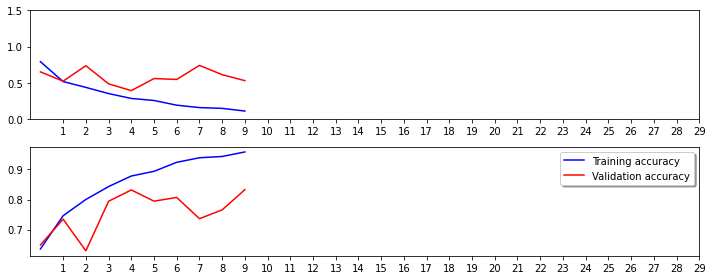

In [126]:
plotting_loss(history_epoch50, 30, y_tick = (0,2,0.5))

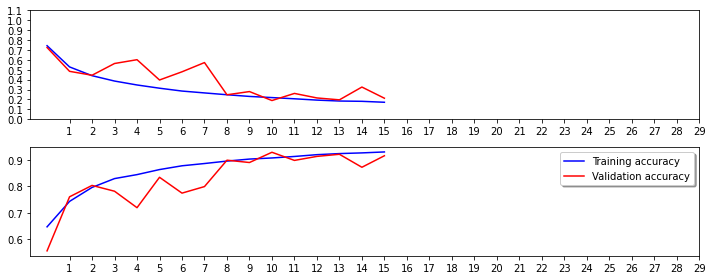

In [127]:
plotting_loss(history_epoch50_augmented, 30, y_tick = (0,1.2,0.1))

## 10 - VGG16 and MobileNetV2 with Tansfer learning models 

### 10.1 - Data augmentation function

Using functional API for easier operation on last few layers for transfer learning.

In [128]:
def data_augmenter():
    '''
    create a Sequential model composed of 2 data augmentation layers
    
    return - tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

In [129]:
# create two new generators without normalization (1/255.)
train_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()
batch_size = 64

train_generator = train_gen.flow_from_dataframe(
    dataframe = train_set,
    directory = destination + '/train/', # file path format
    x_col = 'file',
    y_col = 'categories',
    class_mode = 'categorical',
    target_size = (224,224),
    batch_size = batch_size
)


validation_generator = val_gen.flow_from_dataframe(
    dataframe = val_set,
    directory = destination + '/train/',
    x_col = 'file',
    y_col = 'categories',
    class_mode = 'categorical',
    target_size = (224,224),
    batch_size = batch_size,
    shuffle = False
)

Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


### 10.2 - Building new layers on VGG and MobileNetV2 

In [130]:
input_shape = (224,224, 3)

def transfer_learning(model,image_shape=input_shape, data_augmentation=data_augmenter()):
    ''' 
    define a tf.keras model for binary classification out of specified model
    
    arguments:
        image_shape - image width and height
        data_augmentation - data augmentation function

    returns:
        tf.keras.model
    '''
    if model == 'MobileNetV2':
        base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                       include_top=False, 
                                                       weights='imagenet') # From imageNet
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
        
        
    if model == 'VGG':
        base_model = tf.keras.applications.VGG16(input_shape=input_shape,
                                                    weights="imagenet", 
                                                    include_top=False)
        preprocess_input = tf.keras.applications.vgg16.preprocess_input
        
        
    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape = input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(units = 2)(x)

    new_model = tf.keras.Model(inputs, outputs)
    
    return new_model


### 10.3 - compile new VGG and MobileNetV2 models

In [131]:
model_trans_VGG = transfer_learning('VGG',(224,224,3), data_augmenter())

model_trans_VGG.compile(
              optimizer = 'adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_trans_Mobile = transfer_learning('MobileNetV2',(224,224,3), data_augmenter())

model_trans_Mobile.compile(
                optimizer = 'adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

model_trans_VGG.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0   

In [132]:
model_trans_Mobile.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1280)              0   

### 10.4 - Fitting VGG and MobileNetV2

In [133]:
# Begin fitting with previous function `model_fitting`
history_trans_VGG = model_fitting(model_trans_VGG,train_generator, validation_generator, [earlystop], epochs = 20)

Epoch 1/20
351/351 [==============================] - 111s 300ms/step - loss: 0.4745 - accuracy: 0.8954 - val_loss: 0.0840 - val_accuracy: 0.9764
Epoch 2/20
351/351 [==============================] - 101s 289ms/step - loss: 0.1833 - accuracy: 0.9461 - val_loss: 0.0597 - val_accuracy: 0.9788
Epoch 3/20
351/351 [==============================] - 102s 289ms/step - loss: 0.1455 - accuracy: 0.9527 - val_loss: 0.0502 - val_accuracy: 0.9808
Epoch 4/20
351/351 [==============================] - 103s 292ms/step - loss: 0.1281 - accuracy: 0.9545 - val_loss: 0.0461 - val_accuracy: 0.9820
Epoch 5/20
351/351 [==============================] - 99s 283ms/step - loss: 0.1201 - accuracy: 0.9545 - val_loss: 0.0460 - val_accuracy: 0.9808
Epoch 6/20
351/351 [==============================] - 100s 285ms/step - loss: 0.1209 - accuracy: 0.9532 - val_loss: 0.0393 - val_accuracy: 0.9840
Epoch 7/20
351/351 [==============================] - 101s 287ms/step - loss: 0.1121 - accuracy: 0.9565 - val_loss: 0.0424 - 

In [134]:
history_trans_Mobile = model_fitting(model_trans_Mobile,train_generator, validation_generator, [earlystop], epochs = 20)

Epoch 1/20
351/351 [==============================] - 99s 274ms/step - loss: 0.1534 - accuracy: 0.9446 - val_loss: 0.0539 - val_accuracy: 0.9832
Epoch 2/20
351/351 [==============================] - 94s 268ms/step - loss: 0.1019 - accuracy: 0.9611 - val_loss: 0.0583 - val_accuracy: 0.9808
Epoch 3/20
351/351 [==============================] - 95s 270ms/step - loss: 0.0961 - accuracy: 0.9632 - val_loss: 0.0462 - val_accuracy: 0.9856
Epoch 4/20
351/351 [==============================] - 94s 268ms/step - loss: 0.0970 - accuracy: 0.9628 - val_loss: 0.0470 - val_accuracy: 0.9844
Epoch 5/20
351/351 [==============================] - 89s 255ms/step - loss: 0.0899 - accuracy: 0.9651 - val_loss: 0.0425 - val_accuracy: 0.9868
Epoch 6/20
351/351 [==============================] - 94s 267ms/step - loss: 0.0907 - accuracy: 0.9659 - val_loss: 0.0438 - val_accuracy: 0.9864
Epoch 7/20
351/351 [==============================] - 93s 266ms/step - loss: 0.0898 - accuracy: 0.9646 - val_loss: 0.0414 - val_ac

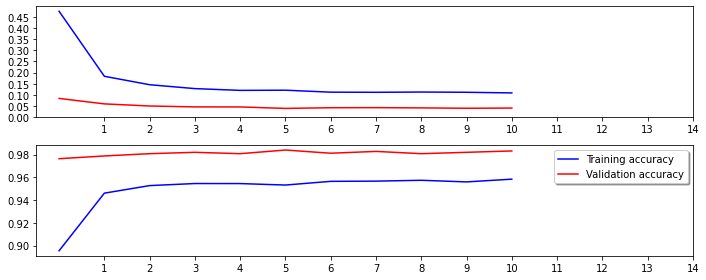

In [143]:
plotting_loss(history_trans_VGG, 15, y_tick = (0,0.5,0.05))

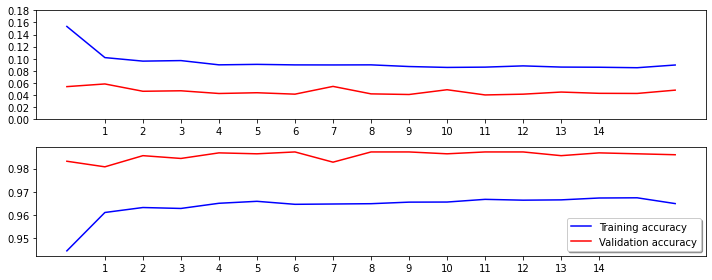

In [136]:
plotting_loss(history_trans_Mobile, 15, y_tick = (0,0.2,0.02))

## 11 - Visualization of results on validation set 

In [137]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def my_confusion_matrix(model):
    '''
    This function creates a confusion matrix to visualize result on validation set.
    
    model - the model used for prediction
    '''
    # generate the prediction made by the model
    predict = model.predict_generator(validation_generator, 
                                      steps=np.ceil(val_set.shape[0] / 64))

    # transform the probability into label 1 and 0
    val_set['predict'] = np.argmax(predict, axis=-1)
    labels = dict((v,k) for k,v in train_generator.class_indices.items())
    val_set['cat/dog'] = val_set['predict'].map(labels)

    fig, ax = plt.subplots(figsize = (9, 6))
    
    # plot confusion matrix
    cm = confusion_matrix(val_set["categories"], val_set["cat/dog"])
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["cat", "dog"])
    disp.plot(cmap = plt.cm.Blues, ax = ax)

    ax.set_title("Validation Set")
    plt.show()


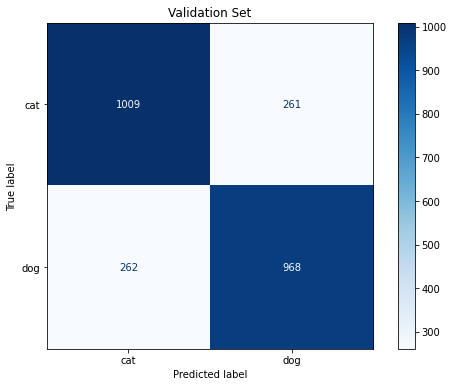

In [138]:
my_confusion_matrix(model_augmented)

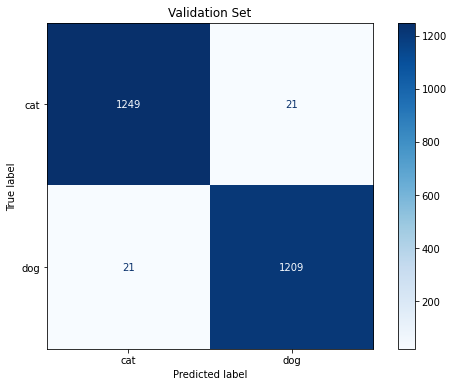

In [139]:
my_confusion_matrix(model_trans_VGG)

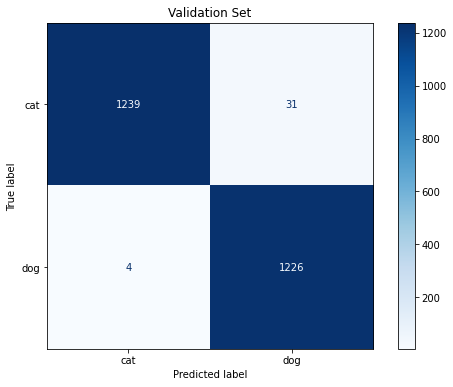

In [140]:
my_confusion_matrix(model_trans_Mobile)

We can see that the accuracy achieved by these two models with transfer learning do not show an obvious difference; but MobileNetV2 seems to perform a little bit better: the final accuracy reaches 98.72%. However, as expected, the training time of MobileNetV2(approximately 94s per epoch) is mostly less time than a VGG network(approximately 102s per epoch). The customized models, without transfer learning, have weaker performances and longest traning time(approximately 103per epoch). But among those customized models, the model trained on augmented data shows a more robust performance on the valitation set. 